# PyTorch for basic regression
Revisiting the task of regression, let's look at trying to model a more complicated function; a sine wave with some Gaussian noise.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from typing import *
from fastprogress import progress_bar
from collections import deque

import torch
from torch import nn, Tensor, optim
from torch.nn.modules.loss import _Loss
from torch.utils.data import DataLoader, Dataset
from torch.nn import MSELoss

In [2]:
n = 200
x = 2*np.pi*np.random.random(n)
y = np.sin(x)+np.random.normal(scale=0.2, size=n)
d = np.array(list(zip(x,y)))
np.random.shuffle(d)
x,y = d[:,0],d[:,1]

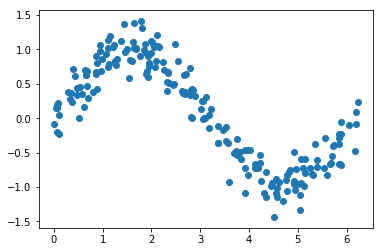

In [3]:
plt.scatter(x, y)

Again, we need our code to define the dataset, network, and wrapper.

In [4]:
class NPDataset(Dataset):
    r'''
    Dataset for dealing with Numpy arrays
    
    Arguments:
        x: input data
        y: Optional target data
        shuffle: whether to shuffle input and target data prior to iteration
        bulk_move: whether to move entire dataset to device at start of iteration (quicker) or move batch by batch (memory efficient)
        bs: batchsize, number of datapoints per minibatch
        device: set to either cuda or cpu, or leave as None for cuda if available else cpu
        drop_last: whether to drop last batch if it is smaller than bs
    '''
    
    def __init__(self, x:np.ndarray, y:Optional[np.ndarray]=None, shuffle:bool=True, bulk_move:bool=True, bs:int=64,
                 device:Optional[torch.device]=None, drop_last:bool=True):
        self.shuffle,self.bulk_move,self.bs,self.drop_last = shuffle,bulk_move,bs,drop_last
        if device is None: self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        else:              self.device = device
        self.x = x.astype('float32')
        if len(self.x.shape) == 1: self.x = self.x[:,None]
        if y is None:
            self.y = y
        else:
            self.y = y.astype('float32')
            if len(self.y.shape) == 1: self.y = self.y[:,None]

    def __len__(self) -> int:
        r'''
        Returns the number of datapoints in the dataset
        '''
        
        return len(self.x)

    def __getitem__(self, idx:int) -> Tuple[Any,Any]:
        r'''
        Returns a single datapoint at the requested index
        '''
        
        if self.y is None: return self.x[idx]
        else:              return self.x[idx], self.y[idx]
        
    def __iter__(self) -> Tuple[Tensor,Tensor]:
        r'''
        Iterates through the entire (shuffled) dataset, yielding minibatches of Tensors on device
        '''
        
        if self.shuffle:
            data = list(zip(self.x, self.y))
            np.random.shuffle(data)
            inputs, targets = zip(*data)
        else:
            inputs, targets = self.x, self.y
            
        if self.bulk_move:  # Moves entire dataset to device
            inputs  = Tensor(inputs).to(self.device)
            if targets is not None: targets = Tensor(targets).to(self.device)
            if self.drop_last:
                for i in range(0, len(inputs)-self.bs+1, self.bs):
                    if targets is not None: yield inputs[i:i+self.bs], targets[i:i+self.bs]
                    else:                   yield inputs[i:i+self.bs]
            else:
                for i in range(0, len(inputs)+1, self.bs):
                    if targets is not None:
                        if i+self.bs < len(inputs): yield inputs[i:i+self.bs], targets[i:i+self.bs]
                        else:                       yield inputs[i:],          targets[i:]
                    else:
                        if i+self.bs < len(inputs): yield inputs[i:i+self.bs]
                        else:                       yield inputs[i:]
        else:
            if self.drop_last:
                for i in range(0, len(inputs)-self.bs+1, self.bs):
                    if targets is not None:
                        yield Tensor(inputs[i:i+self.bs]).to(self.device), Tensor(targets[i:i+self.bs]).to(self.device)
                    else:
                        yield Tensor(inputs[i:i+self.bs]).to(self.device)
            else:
                for i in range(0, len(inputs)+1, self.bs):
                    if targets is not None:
                        if i+self.bs < len(inputs):
                            yield Tensor(inputs[i:i+self.bs]).to(self.device), Tensor(targets[i:i+self.bs]).to(self.device)
                        else:
                            yield Tensor(inputs[i:]).to(self.device),          Tensor(targets[i:]).to(self.device)
                    else:
                        if i+self.bs < len(inputs): yield Tensor(inputs[i:i+self.bs]).to(self.device)
                        else:                       yield Tensor(inputs[i:]).to(self.device)                

In [5]:
class NN(nn.Module):
    r'''
    Full-connected neural network with user-defined depth and width (same width for all dense layers).
    User-configurable output activation function (None for regression, nn.Sigmoid for classification).
    Internal activations are nn.ReLU
    
    Arguments:
        n_int: number of inputs
        depth: number of hidden layers
        width: size of hidden layers
        n_out: width of output layer
        out_act: activation function for output layer (if any)
    '''
    
    def __init__(self, n_in:int, depth:int, width:int, n_out:int, out_act:Optional[Callable[[],nn.Module]]):
        super().__init__()  # nn.Module.__init__ must always be called to correctly initialise class
        if out_act is None: out_act = lambda: None
        self.layers = nn.Sequential(*[self._get_layer(n_in      = n_in      if d   == 0       else width,
                                                      n_out     = width     if d <  depth else n_out,
                                                      act       = nn.ReLU() if d <  depth else out_act(),
                                                      out_layer = d == depth)
                                      for d in range(depth+1)])
        
    @staticmethod
    def _get_layer(n_in:int, n_out:int, act:Optional[nn.Module], out_layer:bool) -> nn.Sequential:
        r'''
        Returns a correctly initialised dense layer and optionally an activation layer, as a Sequential model
        '''
        
        layers = []
        
        # Create a single layer and initialise weights and biases
        layers.append(nn.Linear(n_in, n_out))
        if out_layer: nn.init.xavier_normal_(layers[-1].weight)
        else:         nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu')
        nn.init.zeros_(layers[-1].bias)
        
        # Add activation funtion
        if act is not None: layers.append(act)
        return nn.Sequential(*layers)
    
    def forward(self, x:Tensor) -> Tensor:
        r'''
        Passing input tensor through the neural network and returns the output
        '''
        
        return self.layers(x)

In [6]:
class Model():
    r'''
    Class wrapping a neural network (nn.Module) providing fitting and prediction methods
    
    Arguments:
        model: the network to wrap
        device: set to either cuda or cpu, or leave as None for cuda if available else cpu
        bulk_move: whether to move entire dataset to device at start of iteration (quicker) or move batch by batch (memory efficient)
    '''
    
    def __init__(self, model:nn.Module, device:Optional[torch.device]=None, bulk_move:bool=True):
        if device is None: self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        else:              self.device = device
        self.model = self.to_device(model, self.device)
        self.opt = optim.Adam(self.model.parameters())
        self._n_out = self.get_n_out()
        self.bulk_move = bulk_move
        
    def __repr__(self) -> str:
        return f'''Model:\n{self.model}
        \n\nNumber of trainable parameters: {sum(p.numel() for p in self.model.parameters() if p.requires_grad)}
        \n\nOptimiser:\n{self.opt}
        '''
    
    def get_n_out(self) -> None:
        r'''
        Gets the number of outputs of the network
        '''
        
        l = deque(self.model.parameters(), maxlen=1).pop()
        return len(l.shape)
    
    @staticmethod
    def to_device(x:Union[Tensor,List[Tensor]], device:torch.device) -> Union[Tensor,List[Tensor]]:
        r'''
        Recursively places Tensor(s) onto device

        Arguments:
            x: Tensor(s) to place on device

        Returns:
            Tensor(s) on device
        '''

        if x is None: return x
        if isinstance(x, list): return [Model.to_device(o, device) for o in x]
        return x.to(device)
    
    @staticmethod
    def to_np(x:Tensor) -> np.ndarray:
        r'''
        Converts Tensor x to a Numpy array

        Arguments:
            x: Tensor to convert

        Returns:
            x as a Numpy array
        '''

        return x.cpu().detach().numpy()
    
    def set_lr(self, lr:float) -> None:
        r'''
        Sets learning rate of optimiser
        '''

        self.opt.param_groups[0]['lr'] = lr
    
    def fit(self, x:np.ndarray, y:np.ndarray,
            lr:float, batchsize:int, loss_fn:_Loss, n_epochs:int,
            x_val:Optional[np.ndarray]=None, y_val:Optional[np.ndarray]=None) -> Tuple[List[float],List[float]]:
        r'''
        Fits model to data (optionally using validation data) for a set number of epochs.
        
        Arguments:
            x: training inputs
            y: training targets
            lr: learning rate
            batchsize: size of minibatches
            loss_fn: Loss function to use
            n_epochs: number of epochs to train
            x_val: optional validation inputs
            y_val: optional validation targets
        
        Returns:
            Tuple of train and validation losses
        '''
        
        trn_losses,val_losses = [],[]
        trn_dl = NPDataset(x,y, bs=batchsize, shuffle=True, bulk_move=self.bulk_move, device=self.device)
        self.set_lr(lr)
        
        epoch_pb = progress_bar(range(n_epochs), display=True, leave=True)
        for e in epoch_pb:
            losses = []  # Holder for losses during epoch
            self.model.train()  # Put model into train mode (local gradients saved during forward pass, dropout active, etc.)
            for x, y in trn_dl:  # Loop over batches
                x,y = self.to_device(x, self.device),self.to_device(y, self.device)  # Put data on device
                y_pred = self.model(x)  # Run forward pass of network and get prediction
                loss = loss_fn(y_pred, y)  # Compute loss of prediction
                losses.append(loss.data.item())  # Get value of loss
                self.opt.zero_grad()  # Reset recorded gradients
                loss.backward()  # Propagate loss gradient backwards through network
                self.opt.step()  # Perform one update step to network parameters
            
            trn_losses.append(np.mean(losses))
            if x_val is not None:
                val_losses.append(self.evaluate(x_val,y_val, batchsize=batchsize, loss_fn=loss_fn))
                epoch_pb.comment = f'Epoch {e+1}, best loss: {np.min(val_losses):.4E}'
            else:
                epoch_pb.comment = f'Epoch {e+1}, best loss: {np.min(trn_losses):.4E}'
        self.plot_train_history([trn_losses,val_losses])
        return trn_losses,val_losses
    
    def evaluate(self, x:np.ndarray, y:np.ndarray, batchsize:int, loss_fn:_Loss) -> float:
        r'''
        Computes mean loss on network predicitons for data
        '''
        
        self.model.eval()  # Put model into eval mode no grads saved, dropout turned off, etc.
        loss = []
        dl = NPDataset(x,y, bs=batchsize, shuffle=True, bulk_move=self.bulk_move, device=self.device)
        for x, y in dl:  # Loop over batches
            x,y = self.to_device(x, self.device),self.to_device(y, self.device)  # Put data on device
            y_pred = self.model(x)  # Run forward pass of network and get prediction
            loss.append(loss_fn(y_pred, y).data.item())  # Get value of loss
        return np.mean(loss)
    
    def predict(self, x:np.ndarray, batchsize:Optional[int]=None) -> np.ndarray:
        r'''
        Computes preditions for network on data
        '''
        
        self.model.eval()  # Put model into eval mode no grads saved, dropout turned off, etc.
        if batchsize is None:  # Compute all predictions at once
            x = x.astype('float32')
            if len(x.shape) == 1: x = x[:,None]
            preds = self.model(self.to_device(Tensor(x), self.device))
        else:
            dl = NPDataset(x, bs=batchsize, shuffle=False, bulk_move=self.bulk_move, drop_last=False, device=self.device)
            preds = torch.zeros((len(x),self._n_out), device=self.device)
            for i, x in enumerate(progress_bar(dl, leave=True)):  # Loop over batches
                x = self.to_device(x, self.device)  # Put inputs on device
                ps = self.model(x)  # Run forward pass of network and get prediction
                if len(ps) == batchsize: preds[i*batchsize:(1+i)*batchsize] = ps
                else:                    preds[i*batchsize:]                = ps  # Last batch
        return self.to_np(preds)
    
    @staticmethod
    def plot_train_history(history:Tuple[List[float],List[float]]) -> None:
        r'''
        Plots loss evolution as a function of training epoch
        '''
        plt.figure(figsize=(16,9))
        plt.plot(history[0], label='Training')
        plt.plot(history[1], label='Validation')
        plt.legend(loc='upper right', fontsize=16)
        if history[0][0]/np.min(history[0]) > 50: plt.yscale('log', nonposy='clip')
        plt.grid(True, which="both")
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.xlabel("Epoch", fontsize=24)
        plt.ylabel("Loss", fontsize=24)
        plt.show()

In [7]:
net = NN(n_in=1, depth=6, width=10, n_out=1, out_act=None)

In [8]:
model = Model(net); model

Model:
NN(
  (layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
    (4): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
    (5): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
    (6): Sequential(
      (0): Linear(in_features=10, out_features=1, bias=True)
    )
  )
)
        

Number of trainable parameters: 581
        

Note the use of MSELoss

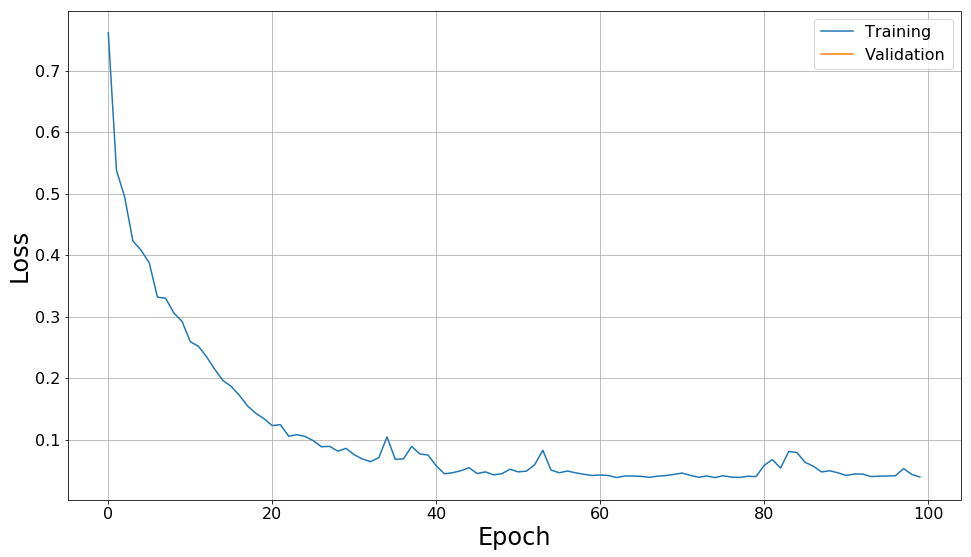

In [9]:
history = model.fit(x=x, y=y, batchsize=64, n_epochs=100, lr=0.01, loss_fn=MSELoss())

In [10]:
preds = model.predict(x)

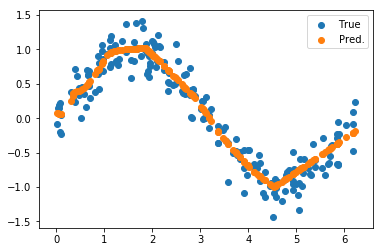

In [11]:
_ = plt.scatter(x, y, label='True')
_ = plt.scatter(x, preds.squeeze(), label='Pred.')
plt.legend();